In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K

from sklearn.metrics import  mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, train_test_split
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter



2025-01-19 11:55:06.001462: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-19 11:55:06.085902: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-19 11:55:06.110570: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-19 11:55:06.264873: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-19 11:55:07.677124: W tensorflow/compiler/tf2

In [2]:

def scale_to_range(data, min_val=-1, max_val=1):
    """
    Scale data to a range (default [-1, 1]) using min-max normalization.
    
    Args:
        data: numpy array or list to be scaled
        min_val: minimum value of desired range (default -1)
        max_val: maximum value of desired range (default 1)
    
    Returns:
        scaled data in the specified range
    """
    data_min = np.min(data)
    data_max = np.max(data)
    
    # Prevent division by zero if all values are the same
    if data_max == data_min:
        return np.zeros_like(data)
    
    # First normalize to [0, 1]
    normalized = (data - data_min) / (data_max - data_min)
    
    # Then scale to [min_val, max_val]
    scaled = normalized * (max_val - min_val) + min_val
    
    return scaled

def unscale_from_range(scaled_data, original_min, original_max, min_val=-1, max_val=1):
    """
    Reverse the scaling operation to get back original values.
    
    Args:
        scaled_data: numpy array or list of scaled values
        original_min: minimum value from original dataset
        original_max: maximum value from original dataset
        min_val: minimum value of current range (default -1)
        max_val: maximum value of current range (default 1)
    
    Returns:
        data in original scale
    """
    # First normalize back to [0, 1]
    normalized = (scaled_data - min_val) / (max_val - min_val)
    
    # Then scale back to original range
    original = normalized * (original_max - original_min) + original_min
    
    return original


def r2_score(y_true, y_pred):
    """
    Calculate R² score using Keras backend operations.
    
    Parameters:
    -----------
    y_true : tensor
        Ground truth values
    y_pred : tensor
        Predicted values
        
    Returns:
    --------
    tensor
        R² score
    """
    # Convert inputs to tensors if they aren't already
    
    y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
    y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)
    
    ss_res = K.sum(K.square(y_true - y_pred))  # Residual sum of squares
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))  # Total sum of squares
    return 1 - ss_res / (ss_tot + K.epsilon())  # Para evitar divisiones por cero



class CustomSeismicLoss(tf.keras.losses.Loss):
    def __init__(self,
                 model,  # The neural network model
                 well_seismic_data,  # Seismic data at well locations S_w
                 well_porosity_data,  # Observed porosity at well locations φ_w
                 lambda_param=0.5,
                 name='custom_seismic_loss'):
        """
        Custom loss function for seismic to porosity mapping.
        
        Args:
            model (tf.keras.Model): Neural network model to predict porosity
            well_seismic_data (tf.Tensor): Seismic data at well locations S_w
            well_porosity_data (tf.Tensor): Observed porosity at well locations φ_w
            lambda_param (float): Regularization parameter
            name (str): Name of the loss function
        """
        super().__init__(name=name)
        self.model = model
        self.well_seismic_data = tf.convert_to_tensor(well_seismic_data, dtype=tf.float32)
        self.well_porosity_data = tf.convert_to_tensor(well_porosity_data, dtype=tf.float32)
        self.lambda_param = lambda_param
    
    def call(self, y_true, y_pred):
        """
        Compute the custom loss.
        
        Args:
            y_true (tf.Tensor): Actual porosity values
            y_pred (tf.Tensor): Predicted porosity values
        
        Returns:
            tf.Tensor: Computed loss value
        """
        # First term: L2 norm of prediction error for full dataset
        first_term = tf.reduce_mean(tf.square(y_true - y_pred))
        
        # Second term: Predict porosity using well seismic data and compare with well porosity
        y_pred_well = self.model(self.well_seismic_data, training=False)
        second_term = (self.lambda_param / 2) * tf.reduce_mean(tf.square(self.well_porosity_data - y_pred_well ))
        
        # Total loss is the sum of both terms
        total_loss = first_term + second_term
        
        return total_loss


class LearningRateSchedulerOnR2(tf.keras.callbacks.Callback):
    def __init__(self, patience=5, factor=0.5, min_lr=1e-6):
        super().__init__()
        self.patience = patience
        self.factor = factor
        self.min_lr = min_lr
        self.r2_scores = []
        self.consecutive_decrease_count = 0

    def on_epoch_end(self, epoch, logs=None):
        r2_score = logs.get('val_r2_score')
        if r2_score is None:
            print("R2 score is not logged; skipping learning rate adjustment.")
            return
        
        self.r2_scores.append(r2_score)
        
        if len(self.r2_scores) > 1:
            if r2_score < self.r2_scores[-2]:
                self.consecutive_decrease_count += 1
            else:
                self.consecutive_decrease_count = 0
            
        if self.consecutive_decrease_count >= self.patience:
            try:
                # Retrieve the old learning rate
                old_lr = float(self.model.optimizer.learning_rate.numpy())
                print(f"Old learning rate: {old_lr:.6f}")

                # Compute the new learning rate
                new_lr = max(old_lr * self.factor, self.min_lr)
                print(f"Computed new learning rate: {new_lr}, type: {type(new_lr)}")

                # Safely update the learning rate
                self.model.optimizer.learning_rate.assign(new_lr)
                print(f"Learning rate successfully updated to: {new_lr:.6f}")

                self.consecutive_decrease_count = 0  # Reset counter
            except Exception as e:
                print(f"Error during learning rate adjustment: {e}")
                print(f"Learning rate object: {self.model.optimizer.learning_rate}, type: {type(self.model.optimizer.learning_rate)}")
                raise


        
        current_lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        print(f"Epoch {epoch+1}: R2 score: {r2_score:.4f}, Learning rate: {current_lr:.6f}")




class LearningRateLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.learning_rates = []

    def on_epoch_end(self, epoch, logs=None):
        # Retrieve the current learning rate and store it
        current_lr = float(self.model.optimizer.learning_rate.numpy())
        self.learning_rates.append(current_lr)
        print(f"Learning rate for epoch {epoch+1}: {current_lr:.6f}")



In [3]:
seis_full= np.load('data/data_decatur/processed/seismic_full.npy')
seis_full.shape

(143, 1211, 86)

In [4]:
X = seis_full[100]
X = X.reshape(-1,86,1,1)
X_norm = scale_to_range(X)


In [5]:
def simplified_cnn(input_shape):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    # Bloque 1
    x1 = tf.keras.layers.Conv2D(6, (5, 1), strides=1, padding='same', kernel_regularizer=tf.keras.regularizers.l1(0.01))(inputs)
    x1 = tf.keras.layers.LeakyReLU()(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)

    
    # Bloque 2
    x2 = tf.keras.layers.Conv2D(12, (5, 1), strides=1, padding='same', kernel_regularizer=tf.keras.regularizers.l1(0.01))(x1)
    x2 = tf.keras.layers.LeakyReLU()(x2)
    x2 = tf.keras.layers.BatchNormalization()(x2)
    
    # Output shape: (86, 1, 12)
    drop = tf.keras.layers.Dropout(0.5)(x2)  # 50% of neurons are randomly dropped during training
    
    flat_bottle_neck = tf.keras.layers.Flatten()(drop)
    dense_bottle_neck = tf.keras.layers.Dense(1032, activation='leaky_relu')(flat_bottle_neck)
    reshape_bottleneck = tf.keras.layers.Reshape((86, 1, 12))(dense_bottle_neck)
    
    # Bloque 3
    x3 = tf.keras.layers.Conv2D(24, (5, 1), strides=1, padding='same', kernel_regularizer=tf.keras.regularizers.l1(0.01))(reshape_bottleneck)
    x3 = tf.keras.layers.LeakyReLU()(x3)
    x3 = tf.keras.layers.BatchNormalization()(x3)

    
    # Bloque 4
    x4 = tf.keras.layers.Conv2D(30, (5, 1), strides=1, padding='same', kernel_regularizer=tf.keras.regularizers.l1(0.01))(x3)
    x4 = tf.keras.layers.LeakyReLU()(x4)
    x4 = tf.keras.layers.BatchNormalization()(x4)

    
    x4 = tf.keras.layers.Conv2D(1, (5, 1), strides=1, padding='same', kernel_regularizer=tf.keras.regularizers.l1(0.01))(x4)
    x4 = tf.keras.layers.LeakyReLU()(x4)
    outputs = tf.keras.layers.BatchNormalization()(x4)

    
    model = tf.keras.Model(inputs, outputs)
    return model

# Definir las dimensiones de entrada
input_shape = (86, 1, 1)
model = simplified_cnn(input_shape)
print(model.summary())

I0000 00:00:1737305710.274592   15916 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1737305710.460501   15916 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1737305710.460562   15916 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1737305710.463738   15916 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1737305710.463817   15916 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 86, 1, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 86, 1, 6)       │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 86, 1, 6)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 86, 1, 6)       │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 86, 1, 12)      │           372 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 86, 1, 12)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 86, 1, 12)      │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 86, 1, 12)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1032)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1032)           │     1,066,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 86, 1, 12)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 86, 1, 24)      │         1,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 86, 1, 24)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 86, 1, 24)      │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 86, 1, 30)      │         3,630 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 86, 1, 30)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 86, 1, 30)      │           120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 86, 1, 1)       │           151 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 86, 1, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 86, 1, 1)       │             4 │
│ (BatchNormalization)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,072,001 (4.09 MB)

 Trainable params: 1,071,855 (4.09 MB)

 Non-trainable params: 146 (584.00 B)

None


In [6]:
model.load_weights('models/training_NFE.weights.h5')

In [7]:
# Extract the convolutional layers
conv_layer_outputs = []
for layer in model.layers:
    if 'conv2d' in layer.name.lower():
        conv_layer_outputs.append(layer.output)


In [8]:
activation_model = tf.keras.Model(inputs=model.input, outputs=conv_layer_outputs)

In [9]:
traces = X_norm

In [10]:
N = traces.shape[0]

I0000 00:00:1737305712.249525   15985 service.cc:146] XLA service 0x7fe344003770 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737305712.249568   15985 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1050, Compute Capability 6.1
2025-01-19 11:55:12.270683: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-19 11:55:12.356277: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


I0000 00:00:1737305713.365327   15985 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

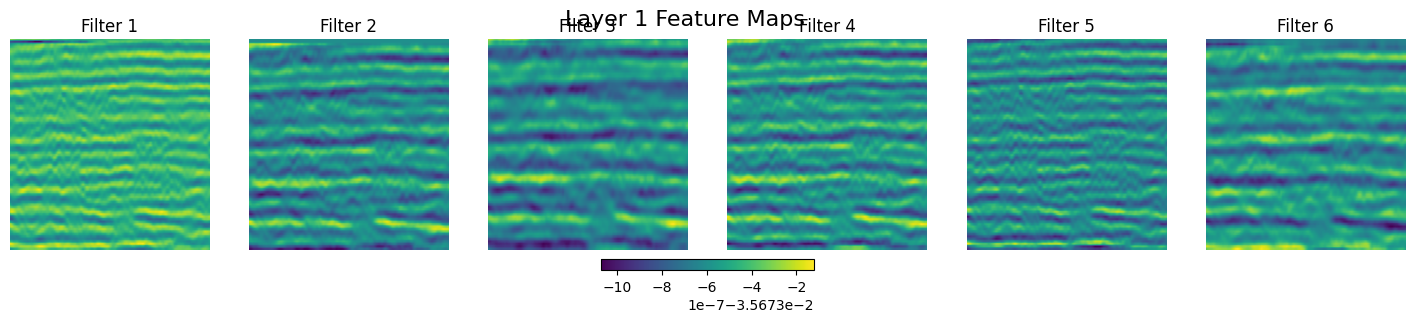

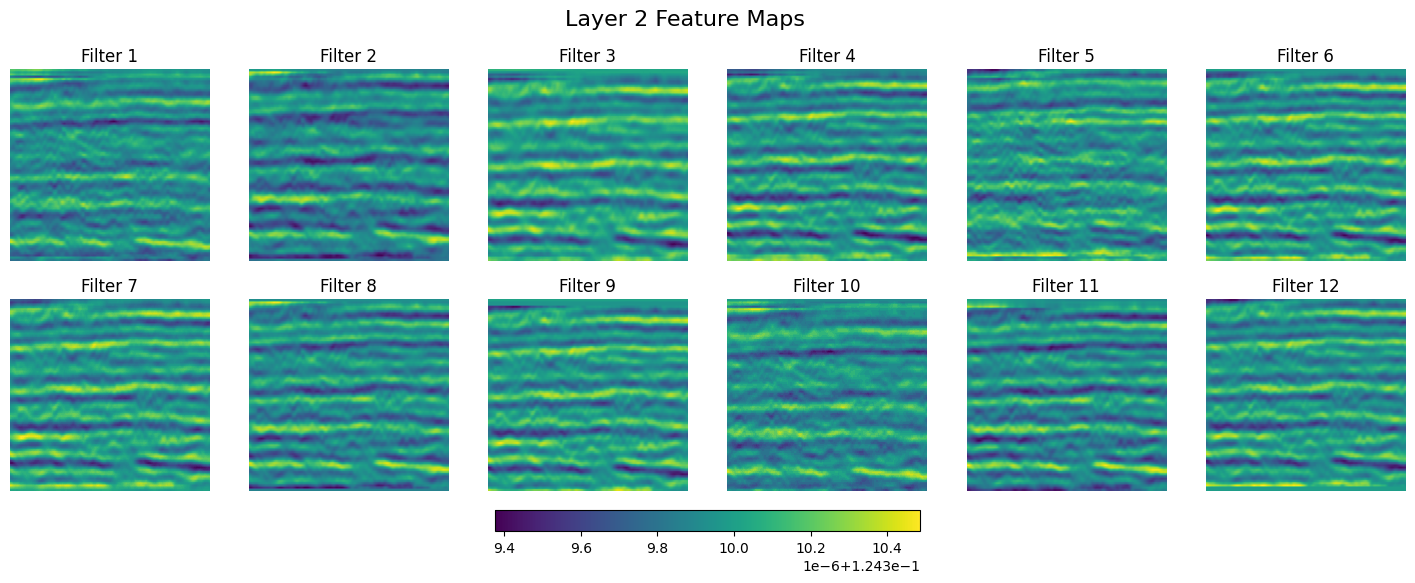

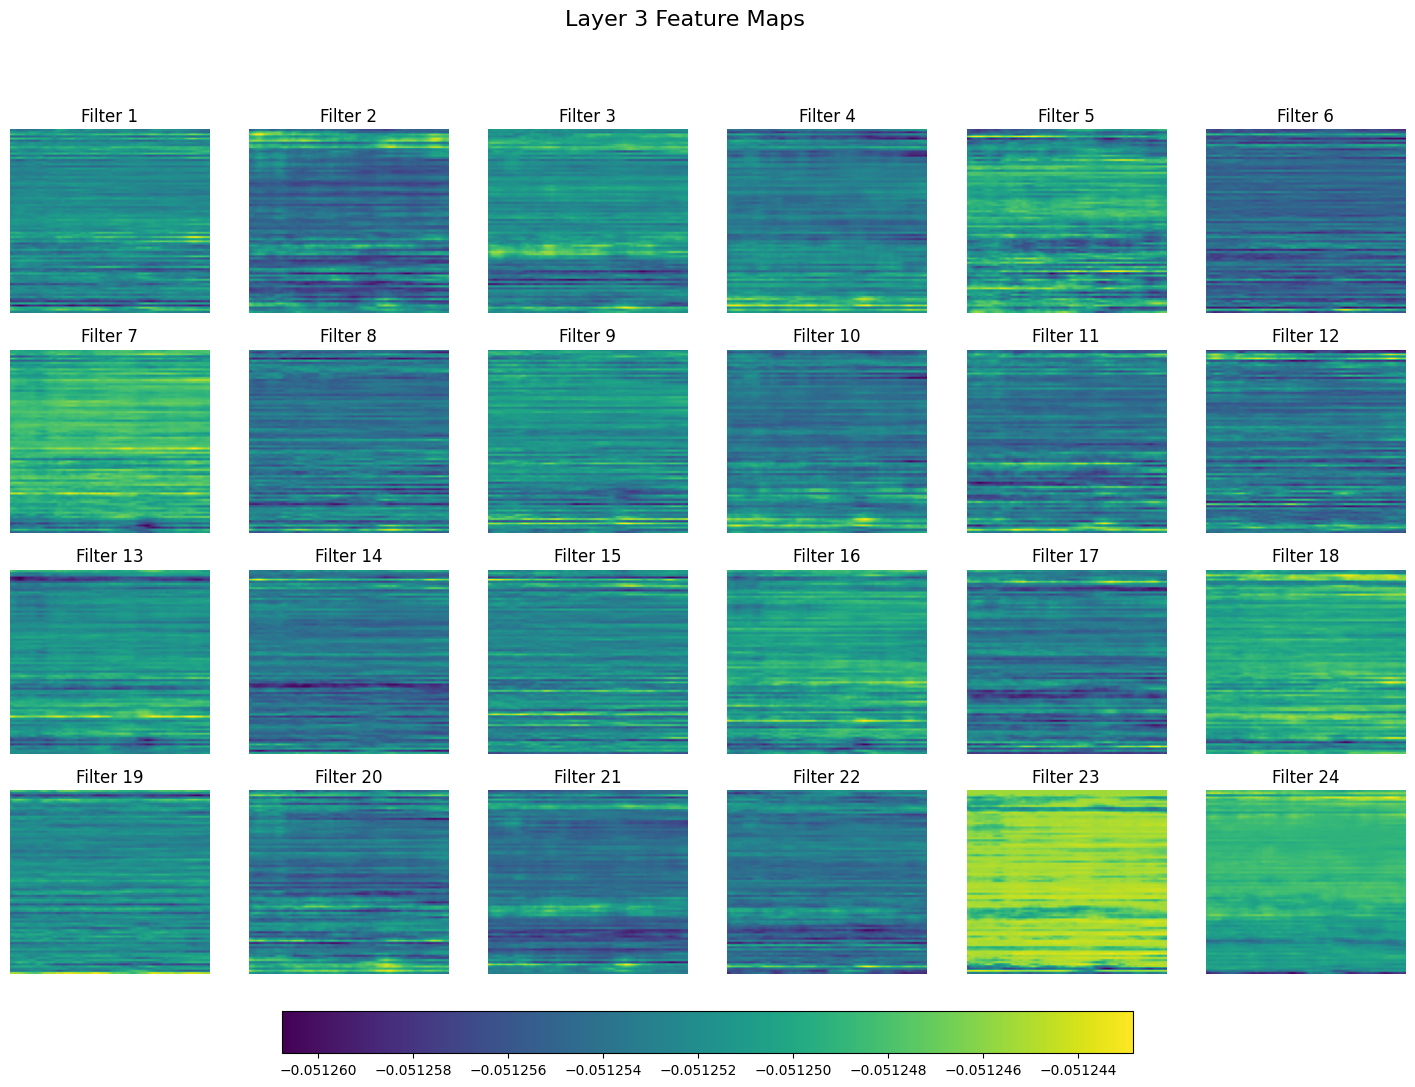

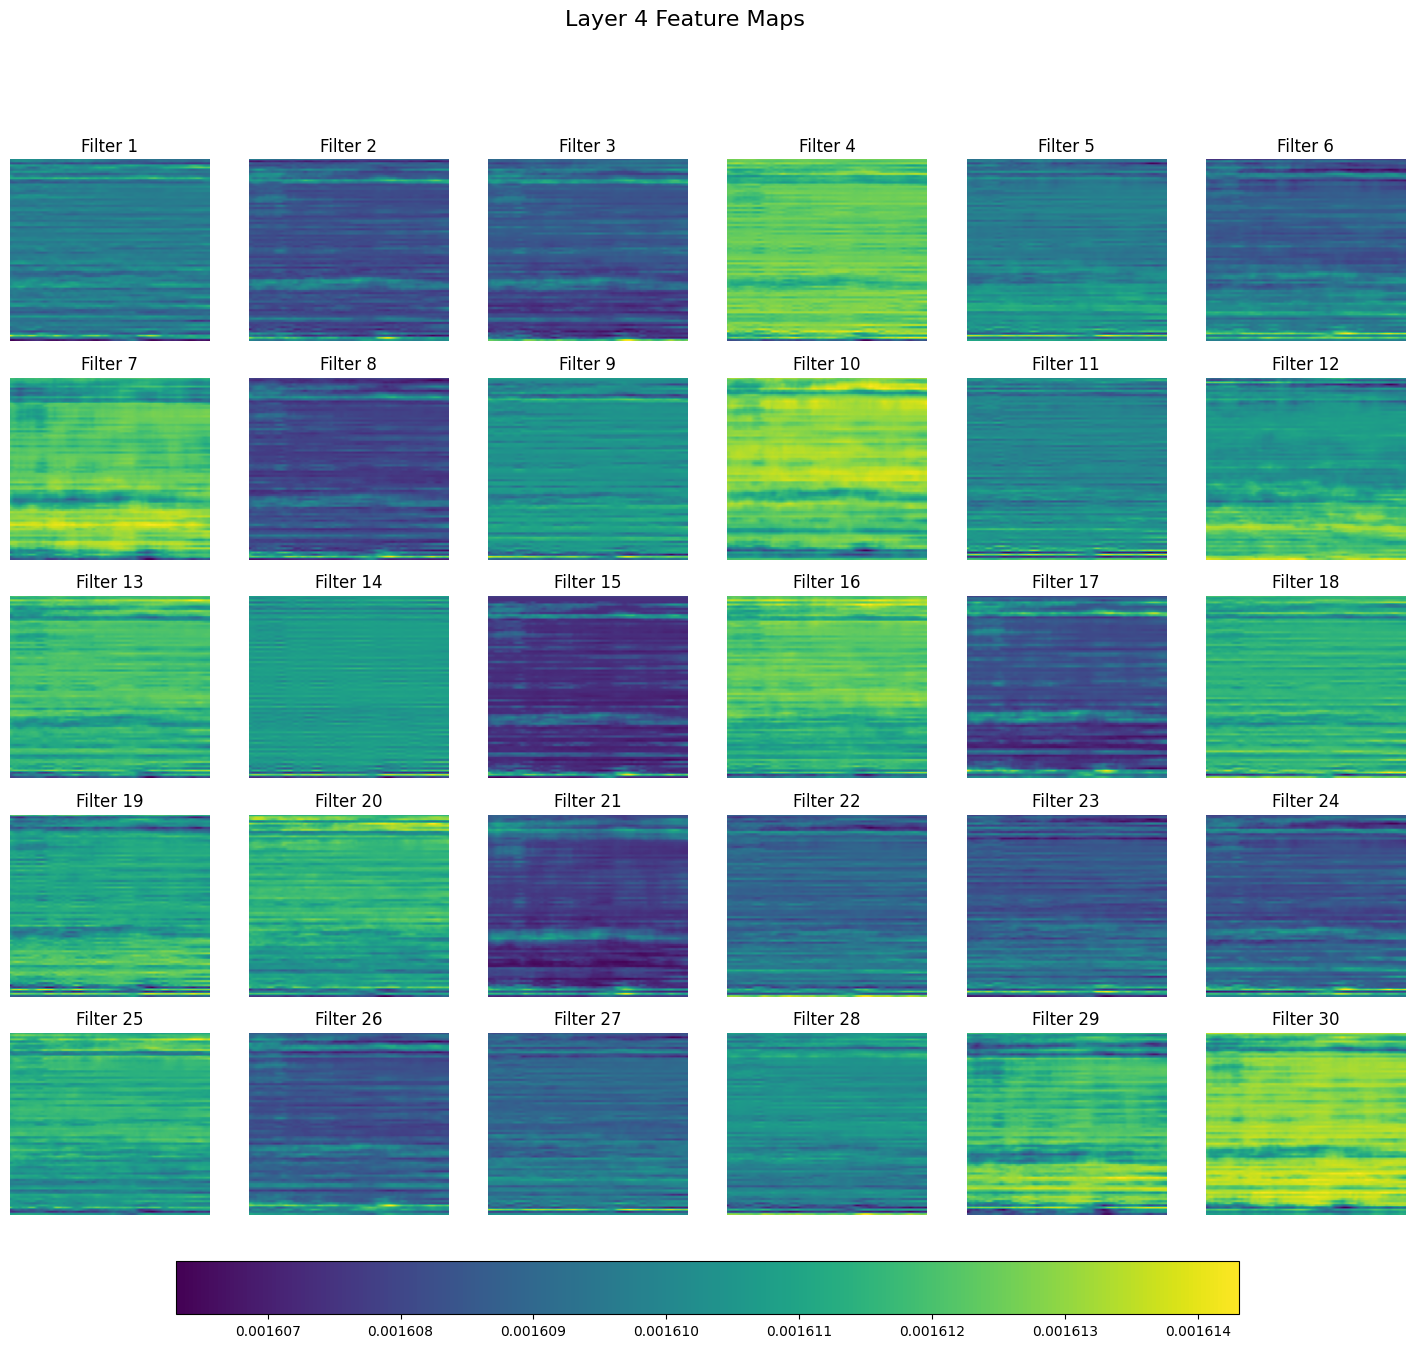

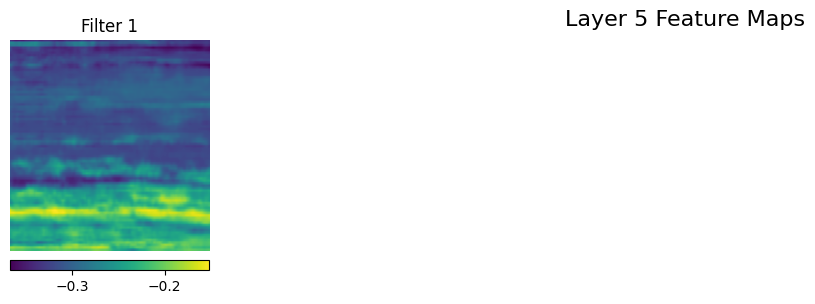

In [11]:
final_feature_maps_per_layer = None

for i in range(N):
    # Get the ith trace and add batch dimension explicitly if needed
    single_trace = traces[i:i+1]  # shape: (1, 86, 1, 1)
    
    # Pass it through the activation model
    fmaps = activation_model.predict(single_trace)
    # fmaps is a list of [ (1, height', width', filters), ... ] for each conv layer
    
    # Process each layer
    if final_feature_maps_per_layer is None:
        # Initialize the list with the first trace's feature maps
        final_feature_maps_per_layer = []
        for fmap in fmaps:
            # Squeeze out the batch dimension: (height', width', filters)
            fmap_squeezed = np.squeeze(fmap, axis=0)
            final_feature_maps_per_layer.append(fmap_squeezed)
    else:
        # Concatenate this trace's fmaps with the existing ones
        for layer_idx, fmap in enumerate(fmaps):
            fmap_squeezed = np.squeeze(fmap, axis=0)
            # Concatenate along the width dimension
            # original: (height', width', filters)
            # after multiple traces: (height', accumulated_width', filters)
            final_feature_maps_per_layer[layer_idx] = np.concatenate(
                [final_feature_maps_per_layer[layer_idx], fmap_squeezed],
                axis=1
            )

for layer_idx, fmap in enumerate(final_feature_maps_per_layer):
    # fmap shape: (height', width', num_filters)
    num_filters = fmap.shape[-1]
    filters_per_row = 6
    rows = (num_filters + filters_per_row - 1) // filters_per_row
    
    fig = plt.figure(figsize=(filters_per_row * 3, rows * 3))
    plt.suptitle(f'Layer {layer_idx+1} Feature Maps', fontsize=16)
    
    first_im = None
    for i in range(num_filters):
        ax = plt.subplot(rows, filters_per_row, i + 1)
        im = ax.imshow(fmap[:, :, i], aspect='auto', cmap='viridis')
        if first_im is None:
            first_im = im
        ax.set_title(f'Filter {i+1}')
        ax.axis("off")
    
    # Add a single colorbar for all filters of this layer
    fig.colorbar(first_im, ax=fig.get_axes(), orientation='horizontal', fraction=0.046, pad=0.04)
    plt.show()

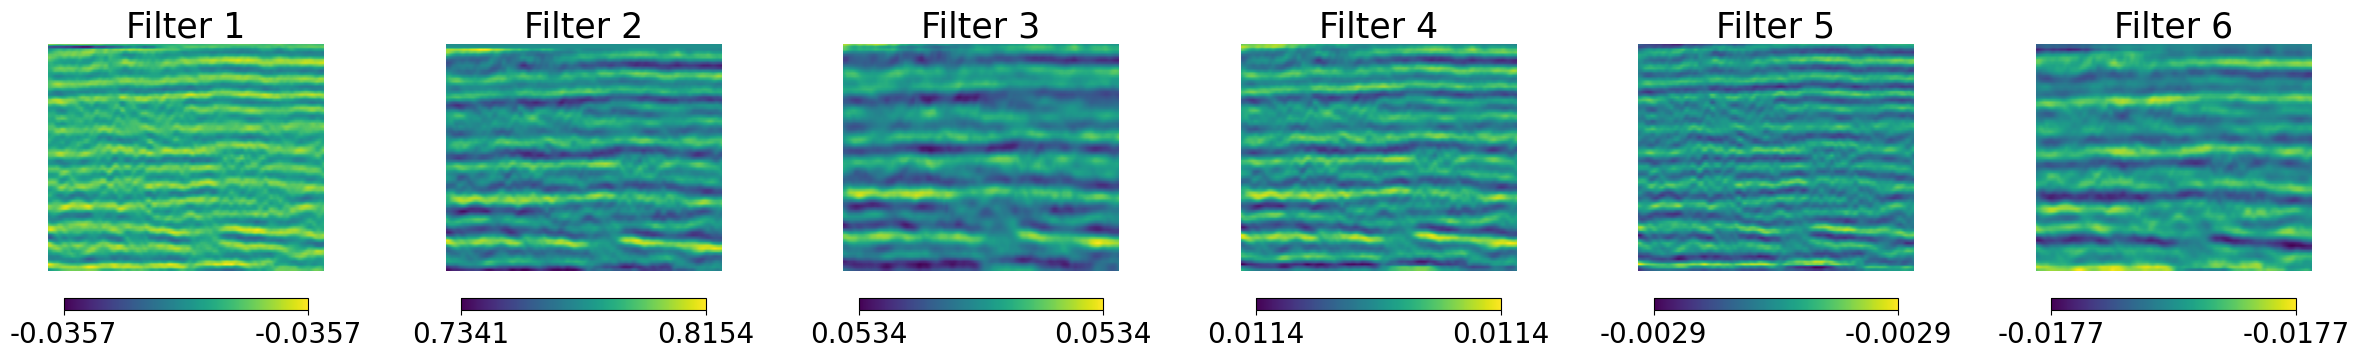

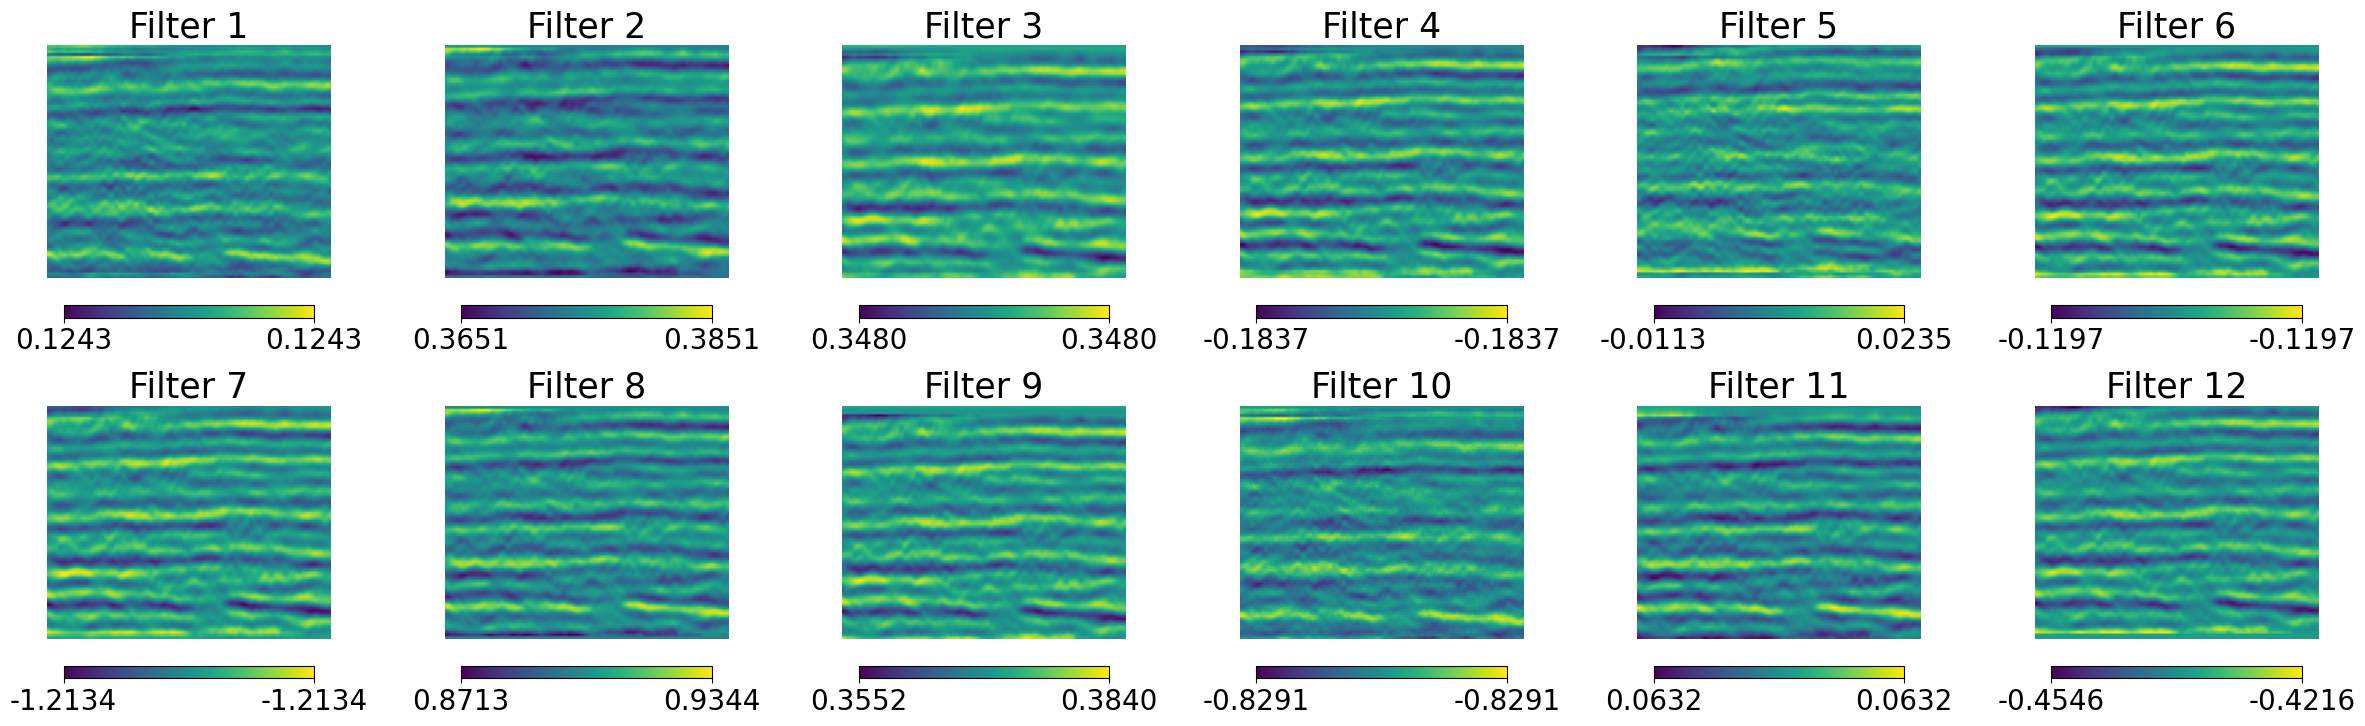

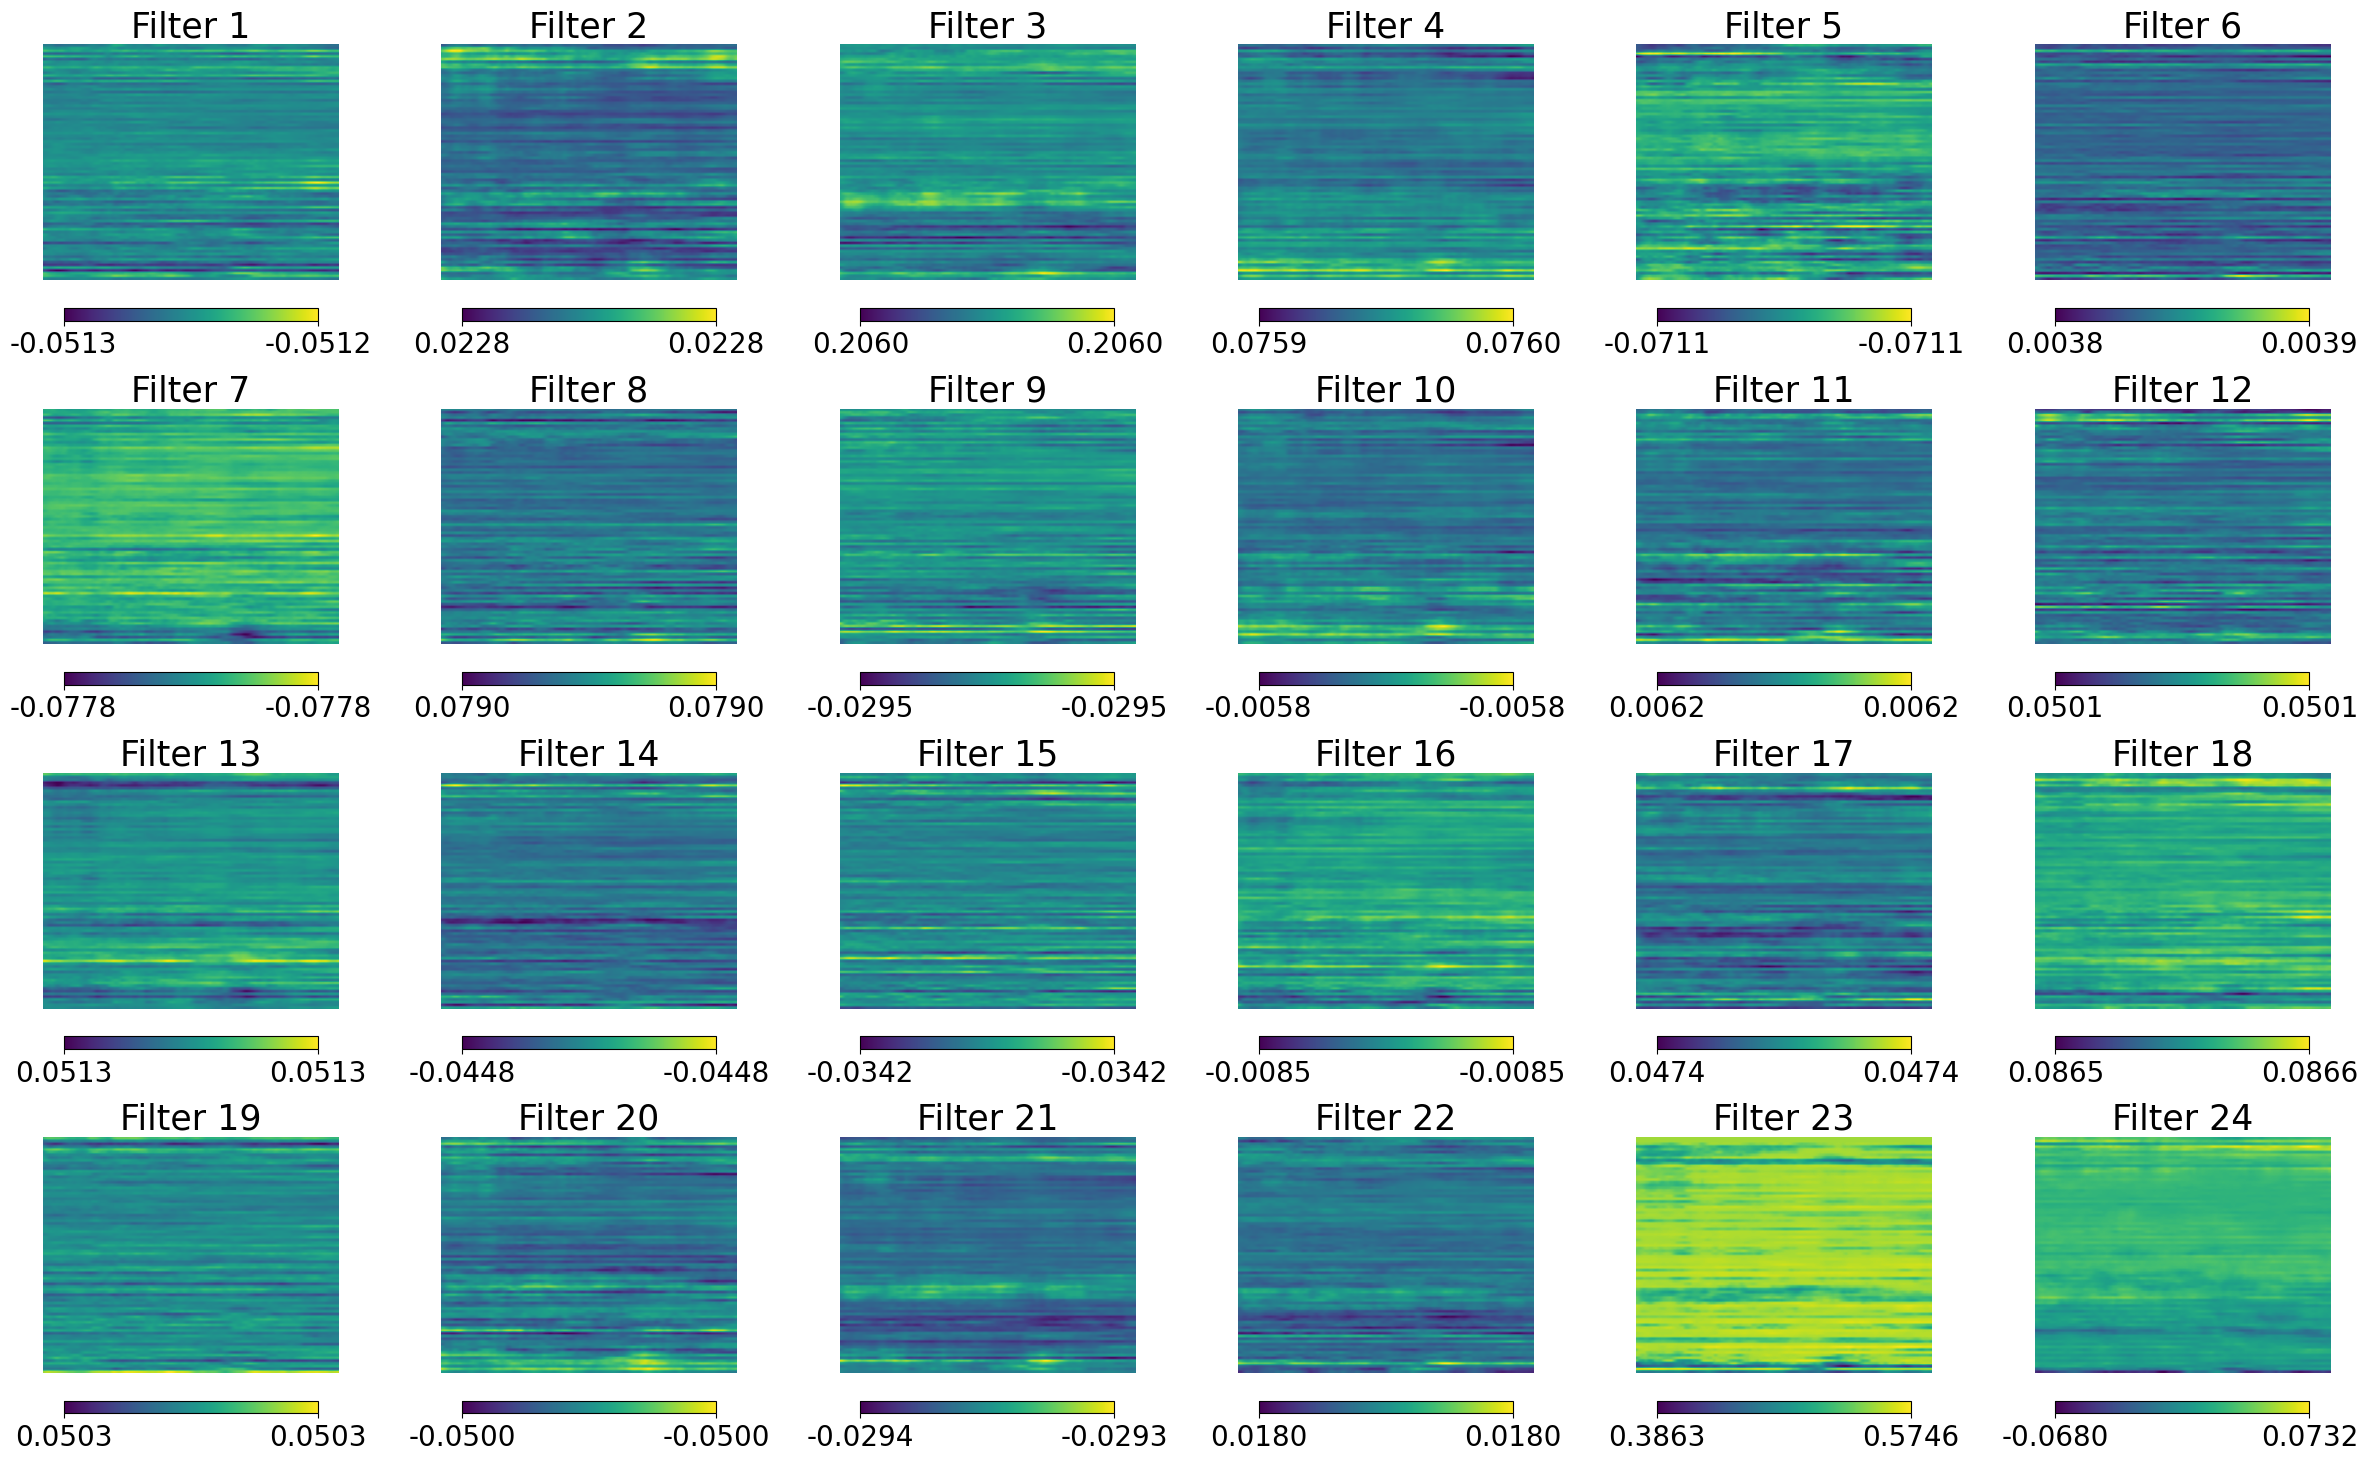

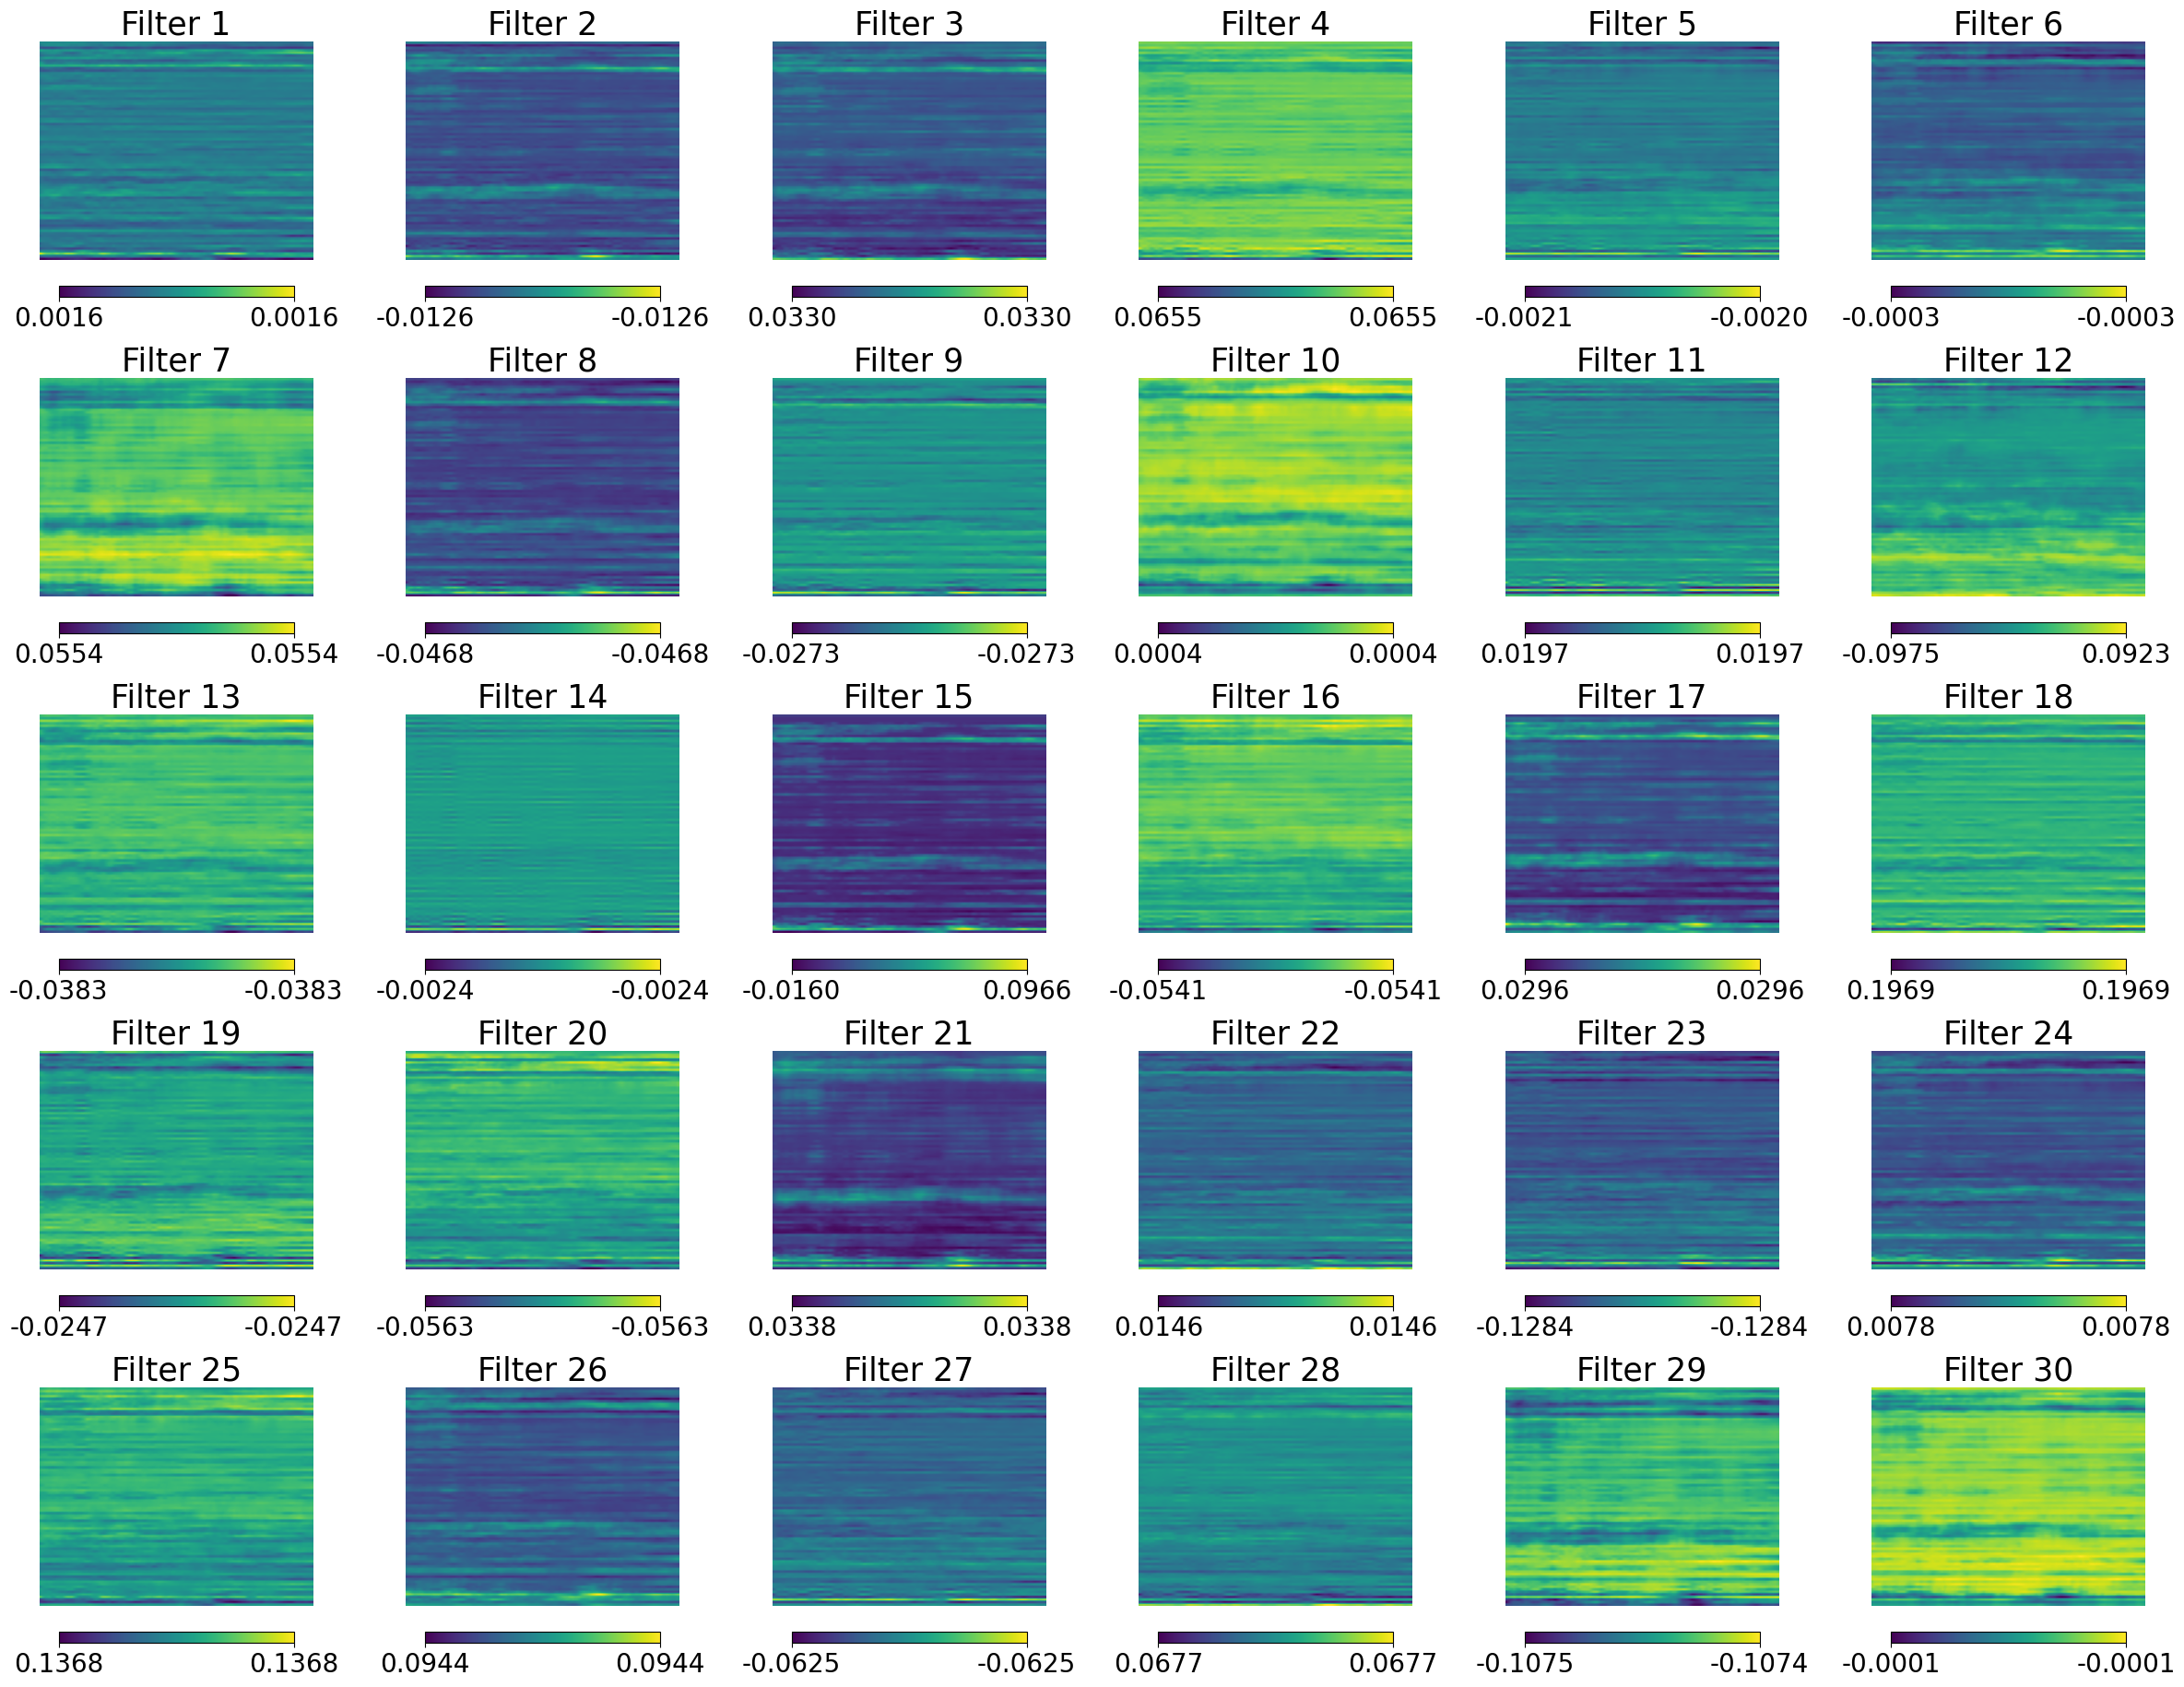

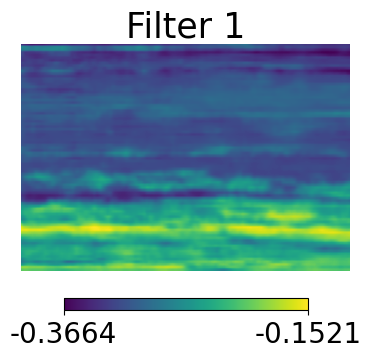

In [12]:
import matplotlib.ticker as mticker
import numpy as np

filters_per_row = 6

for layer_idx, fmap in enumerate(final_feature_maps_per_layer):
    num_filters = fmap.shape[-1]
    rows = (num_filters + filters_per_row - 1) // filters_per_row
    
    fig = plt.figure(figsize=(filters_per_row * 4, rows * 4))  # Adjust figure size for clarity
    
    for i in range(num_filters):
        ax = plt.subplot(rows, filters_per_row, i + 1)
        # Plot the feature map without specifying vmin and vmax
        im = ax.imshow(fmap[:, :, i], aspect='auto', cmap='viridis')
        ax.set_title(f'Filter {i+1}', fontsize=25)
        ax.axis("off")
        
        # Add a horizontal colorbar for each subplot
        cbar = plt.colorbar(im, ax=ax, orientation='horizontal', fraction=0.046, pad=0.1)
        cbar.ax.tick_params(labelsize=20)  # Adjust colorbar tick font size

        # Set exactly 2 ticks
        tick_min, tick_max = im.get_clim()  # Get the data range (vmin and vmax)
        ticks = np.linspace(tick_min, tick_max, 2)  # Create 3 evenly spaced ticks
        cbar.set_ticks(ticks)

        # Customize tick labels to show 4 decimals
        def format_ticks(value, pos):
            return f'{value:.4f}'
        cbar.ax.xaxis.set_major_formatter(mticker.FuncFormatter(format_ticks))

        # Adjust offset text position below the colorbar
        cbar.ax.xaxis.offsetText.set_fontsize(20)

    # Adjust layout before adding suptitle
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    #fig.suptitle(f'Layer {layer_idx+1} Feature Maps', fontsize=30, x=0.5, y=0.98)
    fig.savefig(f'./plots/feature_maps_layer_{layer_idx+1}.eps', format='eps', dpi=150)
    plt.show()


